# Process Renovar NO2 Data according to reference station

## Constants and imports

In [25]:
input_data_directory = 'data/output/'
SENSOR_NAME = 'alpha_no2_conc'
sensor_data_path = input_data_directory + SENSOR_NAME + '_dataframe.csv'
temperature_data_path = input_data_directory + 'chamber_tempdataframe.csv'
temperature_data_path_1HR = input_data_directory + 'chamber_tempdataframe_1hr.csv'

## Load Alphasense NO2 sensor data

In [26]:
import pandas as pd

sensor_data = pd.read_csv(sensor_data_path)
sensor_data['DateTime'] = pd.to_datetime(sensor_data['DateTime'], infer_datetime_format=True)
sensor_data = sensor_data.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
sensor_data.index = sensor_data['DateTime']
sensor_data = sensor_data.drop(columns='DateTime')
sensor_data = sensor_data[['value', 'Tag', 'Hour']].rename(columns={'value': 'measuring'})
sensor_data.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_53831/1999137852.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  sensor_data['DateTime'] = pd.to_datetime(sensor_data['DateTime'], infer_datetime_format=True)


,measuring,Tag,Hour
DateTime,,,
2022-11-20 13:45:00,NaN,STABILIZING,13
2022-11-20 14:00:00,NaN,STABILIZING,14
2022-11-20 14:15:00,NaN,STABILIZING,14
2022-11-20 14:30:00,NaN,STABILIZING,14
2022-11-20 14:45:00,NaN,STABILIZING,14


## Load sensor chamber temperature data

In [27]:
import pandas as pd

temperature_data = pd.read_csv(temperature_data_path)
temperature_data['DateTime'] = pd.to_datetime(temperature_data['DateTime'], infer_datetime_format=True)
temperature_data = temperature_data.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
temperature_data.index = temperature_data['DateTime']
temperature_data = temperature_data.drop(columns='DateTime')
temperature_data = temperature_data[['measuring', 'Tag']]
temperature_data = temperature_data.rename(columns={'measuring': 'temperature', 'Tag': 'Temperature Tag'})
temperature_data.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_53831/2292504063.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  temperature_data['DateTime'] = pd.to_datetime(temperature_data['DateTime'], infer_datetime_format=True)


,temperature,Temperature Tag
DateTime,,
2022-11-21 10:45:00,NaN,MISSING
2022-11-21 11:00:00,NaN,MISSING
2022-11-21 11:15:00,NaN,MISSING
2022-11-21 11:30:00,30.375,VALID
2022-11-21 11:45:00,30.715,VALID


## Merge sensor and temperature data

In [28]:
merged_data = pd.concat([sensor_data, temperature_data], axis=1, join='outer')
sensor_data = merged_data
sensor_data['Temperature Tag'] = sensor_data['Temperature Tag'].fillna(value='VALID')
sensor_data.head()

,measuring,Tag,Hour,temperature,Temperature Tag
DateTime,,,,,
2022-11-20 13:45:00,NaN,STABILIZING,13,NaN,VALID
2022-11-20 14:00:00,NaN,STABILIZING,14,NaN,VALID
2022-11-20 14:15:00,NaN,STABILIZING,14,NaN,VALID
2022-11-20 14:30:00,NaN,STABILIZING,14,NaN,VALID
2022-11-20 14:45:00,NaN,STABILIZING,14,NaN,VALID


## Plot concentration and temperature

<Axes: xlabel='DateTime'>

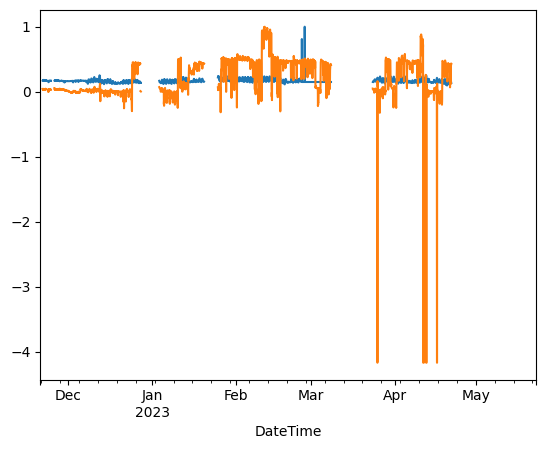

In [29]:
import numpy as np

max_temp_value = sensor_data['temperature'].max()
max_conc_value = sensor_data['measuring'].max()
sensor_data['temperature'].apply(lambda v: v/max_temp_value if not np.isnan(v) else v).plot()
sensor_data['measuring'].apply(lambda v: v/max_conc_value if not np.isnan(v) else v).plot()

## Tag concentration data according to environmental tag

In [30]:
from SensorDataAnalysisService import SensorDataAnalysisService as sensor_analysis

def tag_by_env_tag(current_tag, env_tag):
    if current_tag != 'VALID': return current_tag
    if env_tag != 'VALID': return 'INVALID_ENV'
    return 'VALID'

tags_dataframe = sensor_data[['Tag', 'Temperature Tag']]
sensor_data['Tag'] = tags_dataframe.apply(lambda df: tag_by_env_tag(df[0], df[1]), axis=1)
tags = ['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99', 'INVALID_ENV']
data_contabilization = sensor_analysis.count_tags(tags, sensor_data)
data_contabilization

,#,%
MISSING,5767,32.679776
LTLL,2438,13.815379
GTUL,0,0.0
BADSPIKE,1,0.005667
VALID,1141,6.465688
LTQTLE01,32,0.181334
GTQTLE99,36,0.204001
INVALID_ENV,34,0.192667
TOTAL,17647,100.0


<Axes: xlabel='DateTime'>

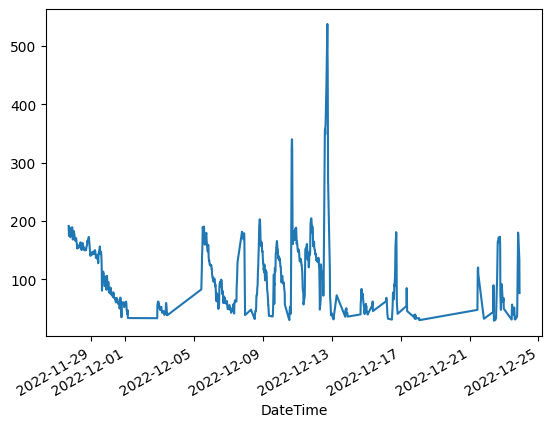

In [31]:
sensor_data[sensor_data['Tag'] == 'VALID']['measuring'].plot()

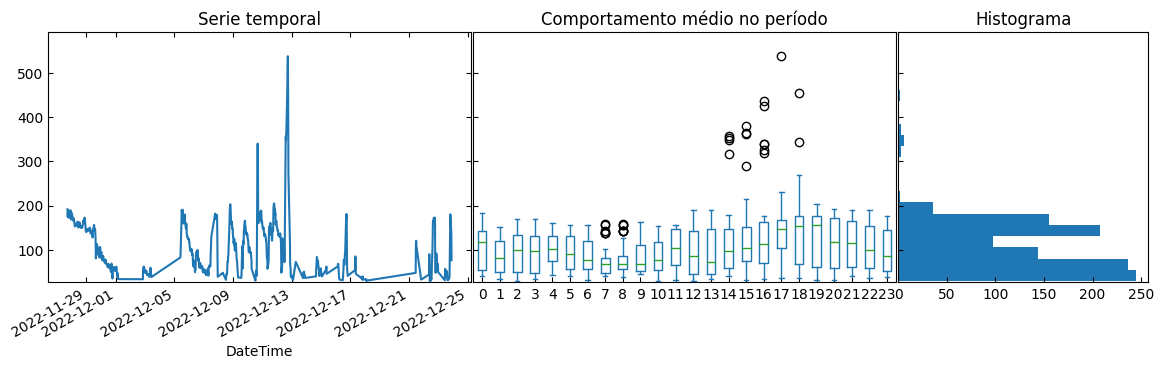

In [32]:
valid_dataframe = sensor_data[sensor_data['Tag'] == 'VALID'].drop(columns=['Tag', 'Temperature Tag'])
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Plot sensor vs. temperature

Spearmans correlation coefficient: 0.09
Samples are correlated (reject H0) p=0.00
Kendall correlation coefficient: 0.09
Samples are correlated (reject H0) p=0.00


Text(0.05, 0.9, 'Coef. de Kendall=0.06, p<0.05')

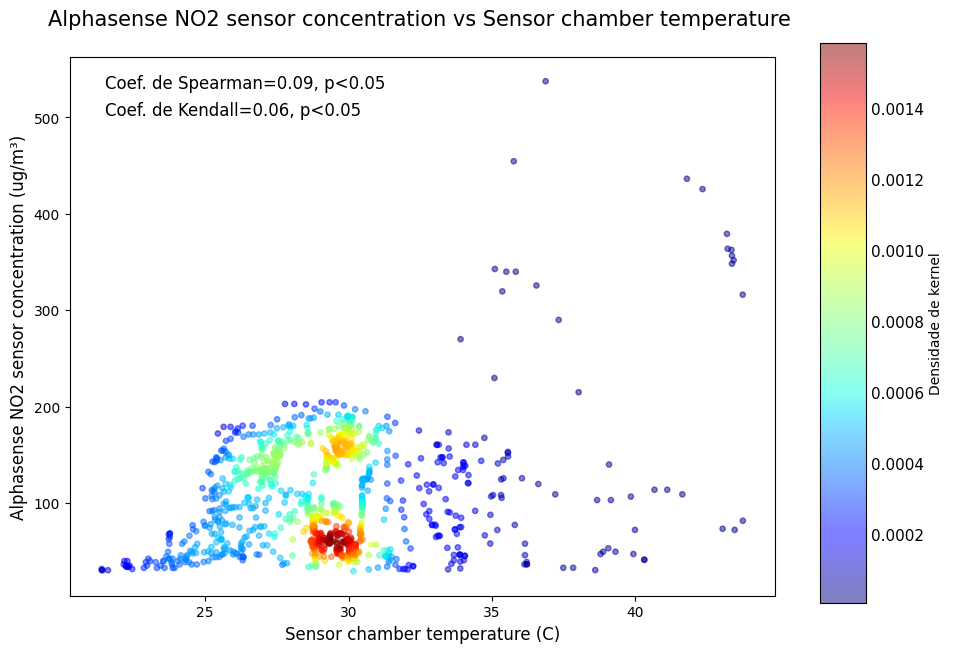

In [33]:
from scipy.stats import kendalltau, spearmanr, gaussian_kde
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*7,7))
xy = np.vstack([valid_dataframe['temperature'],valid_dataframe['measuring']])
z = gaussian_kde(xy)(xy)

plt.scatter(valid_dataframe['temperature'], valid_dataframe['measuring'], c=z, cmap='jet', s=15, alpha=.5)

plt.title('Alphasense NO2 sensor concentration vs Sensor chamber temperature \n', 
          fontdict={'fontsize':15})
plt.xlabel('Sensor chamber temperature (C)', 
           fontsize=12)
plt.ylabel('Alphasense NO2 sensor concentration (ug/m\N{SUPERSCRIPT THREE})', 
           fontsize=12)
coef, p = spearmanr(valid_dataframe['temperature'], valid_dataframe['measuring'], 
                    nan_policy='omit')

print('Spearmans correlation coefficient: %.2f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.2f' % p)
else:
	print('Samples are correlated (reject H0) p=%.2f' % p)

kendall, pken = kendalltau( valid_dataframe['temperature'], valid_dataframe['measuring'], 
                            nan_policy='omit')
print('Kendall correlation coefficient: %.2f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.2f' % p)
else:
	print('Samples are correlated (reject H0) p=%.2f' % p)

cax = plt.axes([0.95, 0.1, 0.05, 0.8])
cbar = plt.colorbar(orientation='vertical', cax=cax, label="Densidade de kernel")
cbar.ax.tick_params(labelsize=11, length=0)

string = 'Coef. de Spearman=%.2f, p<0.05' % coef
plt.text(0.05, 0.95, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Coef. de Kendall=%.2f, p<0.05' % kendall
plt.text(0.05, 0.90, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)

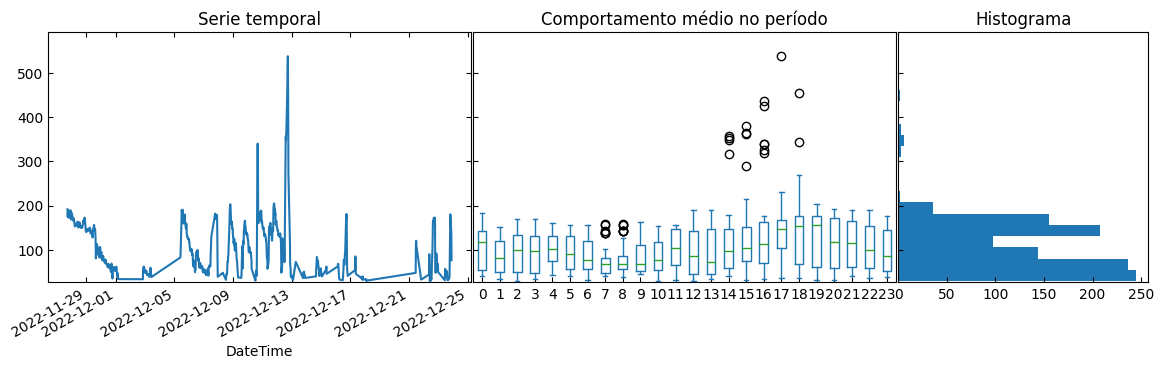

In [34]:
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

# Resample Data

,measuring,Hour,temperature,Count
DateTime,,,,
2022-11-27 17:30:00,182.373362,17,29.78500,3
2022-11-27 18:30:00,188.127215,18,30.13125,4
2022-11-27 19:30:00,175.393318,19,30.09375,4
2022-11-27 20:30:00,185.269497,20,30.03750,4
2022-11-27 21:30:00,179.436459,21,29.96875,4


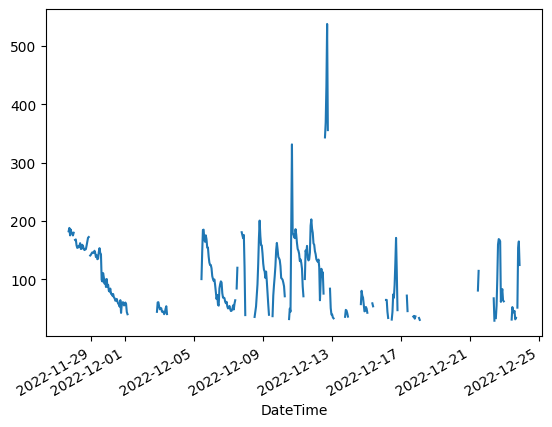

In [35]:
data_1HR = valid_dataframe.resample('H').mean()
data_1HR['Hour'] = data_1HR.index.hour
data_1HR['Count'] = (valid_dataframe['measuring'].resample('H').count())
data_1HR.index = data_1HR.index.map(lambda t: t.replace(minute=30, second=0))
data_1HR['measuring'].plot()
data_1HR.head()

#### Tag hourly data according to the number of samples in an hour
At least 3 samples must be valid in an hour (75 %) for the hourly data be considered as valid

<Axes: xlabel='DateTime'>

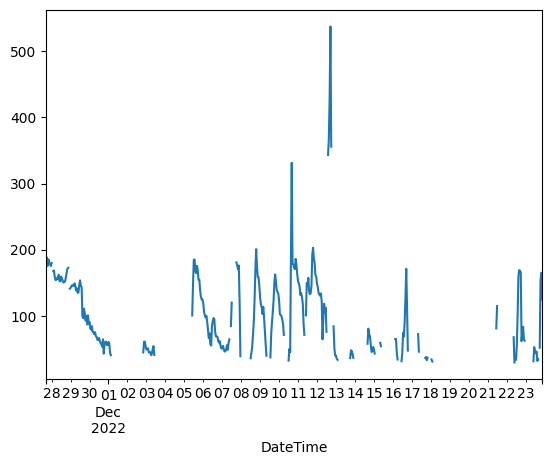

In [36]:
data_1HR['Tag'] = (data_1HR['Count'].map(lambda c: 'VALID' if c >= 3 else 'LOWSAMPLES'))
data_1HR['measuring'].resample('H').mean().plot()

#### Valid data contabilization

In [37]:
tags = ['LOWSAMPLES','VALID'] 
data_contabilization = sensor_analysis.count_tags(tags, data_1HR)
data_contabilization

,#,%
LOWSAMPLES,351,55.802862
VALID,278,44.197138
TOTAL,629,100.0


In [38]:
valid_data_1HR = data_1HR[data_1HR['Tag'] == 'VALID']

# Save Data

In [39]:
import os

output_directory_path = 'data/output/'
processing_directory_path = '../data-processing/input/'
valid_filename = '_and_temp_valid.csv'
valid_filename_1HR = '_and_temp_valid_1HR.csv'

valid_1HR_file_path_output = output_directory_path + SENSOR_NAME + valid_filename_1HR
valid_file_path_output = output_directory_path + SENSOR_NAME + valid_filename

valid_processing_1HR_file_path = processing_directory_path + SENSOR_NAME + valid_filename_1HR
valid_processing_file_path = processing_directory_path + SENSOR_NAME + valid_filename

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

if not os.path.exists(processing_directory_path):
    os.makedirs(processing_directory_path)

valid_dataframe.to_csv(valid_file_path_output)
valid_data_1HR.to_csv(valid_1HR_file_path_output)

valid_dataframe.to_csv(valid_processing_file_path)
valid_data_1HR.to_csv(valid_processing_1HR_file_path)